In [263]:
## Exercice 1

In [2]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
from sklearn import tree

In [3]:
# Get some images
fid = open('GTI770_label_data_set.csv', 'r') 
next(fid) # skip les headers (la premiere ligne)

classDict = {}

X = np.zeros((100, 3, 424, 424), dtype=int)
Y = np.zeros((100, 2), dtype=object)

count = 0
for line in fid:
    element = line.rstrip('\n').split(',')
    
    if element[1] not in classDict:
        classDict[element[1]] = 0     
    elif element[1] in classDict and classDict[element[1]] < 50:
        classDict[element[1]] += 1;
    else:
        continue
    
    imagePath = 'images/' + element[0] + '.jpg'
    if not os.path.exists(imagePath):
        classDict[element[1]] -= 1    # S'assure d'avoir des images qui existe
        continue
        
    img = cv2.imread(imagePath).reshape(3,424,424)
    img = img[:, :, ::-1]
    
    X[count] = img
    Y[count] = [count, element[1]]
    
    count += 1
    if count >= 100:
        break

fid.close() 

In [6]:
def GenerateRandomNumbersList(ArangeLength, GeneratedSetLength):
    a = np.arange(ArangeLength)
    np.random.shuffle(a)
    randomSet = a[:GeneratedSetLength]
    return randomSet

rand1 = GenerateRandomNumbersList(50, 10)
rand2 = GenerateRandomNumbersList(50, 10)

YSorted = Y[Y[:,1].argsort()]
listSmooth = YSorted[:len(YSorted)//2]
listSpiral = YSorted[len(YSorted)//2:]

def RandomList(list, randNumbers):
    listRand = np.zeros((10, 3, 424, 424), dtype=int)
    for i in range(0, len(randNumbers)):
        randY = list[randNumbers[i]]        
        listRand[i] = X[randY[0]]
    return listRand
    
listRandSmooth = RandomList(listSmooth, rand1)
listRandSpiral = RandomList(listSpiral, rand2)

def ShowImageList(imageList):
    f, axarr = plt.subplots(1, len(imageList), figsize=(20,20))
    for i in range(0, len(imageList)):
        axarr[i].imshow(imageList[i].reshape(len(imageList[0][0]),len(imageList[0][0][0]),3))      
    plt.show()
    
#print("Smooth :")
#ShowImageList(listRandSmooth)
#print("Spiral :")
#ShowImageList(listRandSpiral)

In [7]:
Y_train = np.concatenate((listSmooth[:35], listSpiral[:35]), axis=0)
Y_test = np.concatenate((listSmooth[-15:], listSpiral[-15:]))

def GenerateXFromY(listY):
    listX = np.zeros((len(listY), 3, 424, 424), dtype=int)
    for i in range(len(listY)):
        imageIndex = listY[i]
        listX[i] = X[imageIndex[0]]
    return listX

X_train = GenerateXFromY(Y_train)
X_test = GenerateXFromY(Y_test)

#----------------------
#For debug :
# print(len(Y_train))
# print(Y_train)
# print(len(Y_test))
# print(Y_test)
# print(len(X_train))
# print(len(X_test))
#----------------------

In [8]:
def crop(img,cropx,cropy):
    x,y,rgb = img.shape #Prend les valeurs de l'image
    startx = x//2-(cropx//2) #Trouve la nouvelle coordonnée startx
    starty = y//2-(cropy//2) #Trouve la nouvelle coordonnée starty
    return img[startx:startx+cropx,starty:starty+cropy] #Réajuste l'image selon les nouvelle coordonnée et la longueur du crop

X_train_crop = np.zeros((len(X_train), 3, 50, 50), dtype=np.uint8)
for i in range(0, len(X_train)):
    X_train_crop[i] = crop(X_train[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
#-----------------------
#For Debug :
# print(len(X_train_crop))
# print(len(X_train_crop[0][0]))
# print(len(X_train_crop[0][0][0]))
#-----------------------    

In [9]:
def showCropComparison(imgIndex):
    img = X_train[imgIndex].reshape(424,424,3)
    img_cropped = np.zeros((50, 50, 3), dtype=int)
    img_cropped =  X_train_crop[imgIndex].reshape(50,50,3)
    f, axarr = plt.subplots(1, 2, figsize=(10,10))
    axarr[0].imshow(img_cropped)
    axarr[1].imshow(img)
    plt.show()
    
#print("Smooth - cropped (left) vs untouched (right) :")
#showCropComparison(0)
#print("Spiral - cropped (left) vs untouched (right) :")
#showCropComparison(58)


In [10]:
def RgbToGray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]) #Transforme l'image couleur en grayscale

X_train_binary = np.zeros((len(X_train_crop), 50, 50), dtype=float)
for i in range(0, len(X_train_crop)):
    grayscale = RgbToGray(X_train_crop[i].reshape(50,50,3))
    thresh_img = np.where(grayscale>128, 255, 0)
    X_train_binary[i] = thresh_img

#-------------------------------------------
#For debug :
#plt.imshow(X_train_binary[45], cmap=plt.cm.gray)
#plt.imshow(X_train_crop[52].reshape(50,50,3))
#-------------------------------------------

In [11]:
#Le fait d'avoir une matrice avec le nombre de pixels noires et blanches permet de faire le différence entre
#les galaxies de type "spiral" et "smooth". Les spirals ont tendence à être plus étendu et on donc moins de pixels blanches que 
#les galaxies de types smooth qui ont tendence de faire des taches blanches plus prononcées.

X_train_plot = np.zeros((len(X_train_binary), 2), dtype=int)
for i in range(0, len(X_train_binary)):
    X_train_plot[i][0] = np.sum(X_train_binary[i] == 255) #Number of white pixels
    X_train_plot[i][1] = np.sum(X_train_binary[i] == 0) #Number of black pixels

#-------------------------------------------
#For debug :
#print(X_train_plot)
#-------------------------------------------

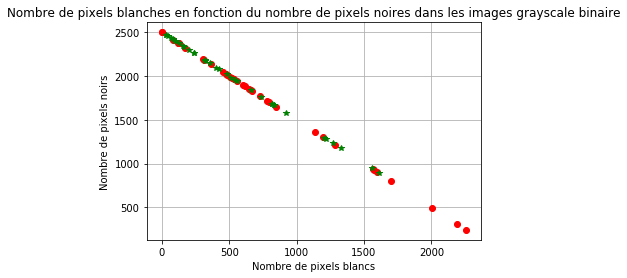

In [12]:
length_smooth = 0
length_spiral = 0

for element in Y_train :
    if element[1] == "smooth" :
        length_smooth += 1
    elif element[1] == "spiral" :
        length_spiral += 1
        
X_coord_smooth = np.zeros(length_smooth, dtype=int)
Y_coord_smooth = np.zeros(length_smooth, dtype=int)
X_coord_spiral= np.zeros(length_spiral, dtype=int)
Y_coord_spiral = np.zeros(length_spiral, dtype=int)

count_smooth = 0
count_spiral = 0
for i in range(0, len(X_train_plot)):
    if Y_train[i][1] == "smooth" :
        X_coord_smooth[count_smooth] = X_train_plot[i][0]
        Y_coord_smooth[count_smooth] = X_train_plot[i][1]
        count_smooth += 1
    elif Y_train[i][1] == "spiral" :
        X_coord_spiral[count_spiral] = X_train_plot[i][0]
        Y_coord_spiral[count_spiral] = X_train_plot[i][1]
        count_spiral += 1
    
plt.plot(X_coord_smooth, Y_coord_smooth, 'ro')
plt.plot(X_coord_spiral, Y_coord_spiral, 'g*')
plt.xlabel('Nombre de pixels blancs')
plt.ylabel('Nombre de pixels noirs')
plt.title('Nombre de pixels blanches en fonction du nombre de pixels noires dans les images grayscale binaire')
plt.grid(True)
plt.show()

In [13]:
#separate color channels

X_train_crop_red = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_green = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_blue_high = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_blue_mid = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_yellow = np.zeros((len(X_train_crop),50, 50), dtype=int)

def ShowColorComparison(imgIndex):
    img = X_train[imgIndex].reshape(424,424,3)
    img_cropped = np.zeros((50, 50, 3), dtype=int)
    img_cropped =  X_train_crop[imgIndex].reshape(50,50,3)
    f, axarr = plt.subplots(1, 7, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(img_cropped)
    
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_red, img_green, img_blue_high, img_blue_mid = SplitColors(img_cropped)
    
    axarr[2].imshow(img_red, cmap=plt.cm.Reds)
    axarr[3].imshow(img_green, cmap=plt.cm.Greens)
    axarr[4].imshow(img_blue, cmap=plt.cm.Blues)
    axarr[5].imshow(X_train_binary[imgIndex], cmap=plt.cm.gray)
    axarr[6].imshow(img_blue2, cmap=plt.cm.gray)
    plt.show()
    
def SplitRgb(rgb, th_red, th_green, th_blue):
    red = rgb[:, :, 0] > th_red
    green = rgb[:, :, 1] > th_green
    blue = rgb[:, :, 2] > th_blue
    return red, green, blue

def AvgYellow(rgb, th_yel):
    yellow = rgb[:, :, 0]+rgb[:, :, 1]/2 > th_yel
    return yellow

def ShowAll():
    for i in range(0, len(X_train)):
        print("%d- %s" %(i, Y_train[i][1]))
        ShowColorComparison(i)
        
def splitColors(img_cropped):
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_yellow = np.zeros((50, 50, 1), dtype=int)
    img_red, img_green, img_blue_high = SplitRgb(img_cropped, 200, 160, 160)
    img_blue_mid = np.where(img_cropped[:,:,2]>90, 255, 0)
    img_yellow = AvgYellow(img_cropped, 160)
    return img_red, img_green, img_blue_high, img_blue_mid, img_yellow

def SplitAllImagesColors():
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_yellow = np.zeros((50, 50, 1), dtype=int)
    
    for i in range(0, len(X_train_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = splitColors(X_train_crop[i].reshape(50,50,3))
        X_train_crop_red[i] = img_red
        X_train_crop_green[i] = img_green
        X_train_crop_blue_high[i] = img_blue_high
        X_train_crop_blue_mid[i] = img_blue_mid
        X_train_crop_yellow[i] = img_yellow
        
#DOESN'T WORK      
# def Normalize(array):
#     max = array.max()
#     min = array.min()
#     for i in range(0, len(array)):
#         array[i] = array[i] - min / max - min
#     return array


SplitAllImagesColors()
#-------------------------------------------
#For debug :
# ShowAll()

#print(len(X_train_crop_green))
#print(len(X_train_crop_blue_high))
#print(len(X_train_crop_blue_mid))
#-------------------------------------------

In [14]:
#notes
# if nb_pixel_white in each_channels > 50 ==> smooth
# if nb_pixel_white in grayscale > 600 ==> smooth
# blue2_nb_pixel_white > grayscale_nb_pixel_white ==> spiral
# green == center, center + blue ==> spiral
#



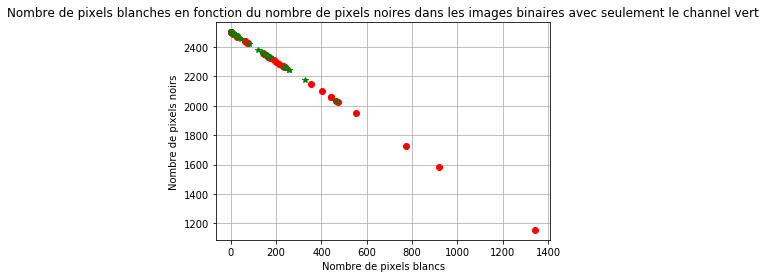

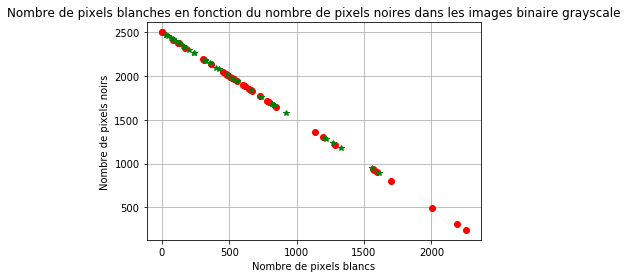

In [15]:
#Intensité du centre

def TracePlot(array, titre, titre_x, titre_y):        
    length_smooth = 0
    length_spiral = 0

    for element in Y_train :
        if element[1] == "smooth" :
            length_smooth += 1
        elif element[1] == "spiral" :
            length_spiral += 1
            
    X_coord_smooth = np.zeros(length_smooth, dtype=float)
    Y_coord_smooth = np.zeros(length_smooth, dtype=float)
    X_coord_spiral= np.zeros(length_spiral, dtype=float)
    Y_coord_spiral = np.zeros(length_spiral, dtype=float)

    count_smooth = 0
    count_spiral = 0
    for i in range(0, len(X_train)):
        if Y_train[i][1] == "smooth" :
            X_coord_smooth[count_smooth] = array[i][0]
            Y_coord_smooth[count_smooth] = array[i][1]
            count_smooth += 1
        elif Y_train[i][1] == "spiral" :
            X_coord_spiral[count_spiral] = array[i][0]
            Y_coord_spiral[count_spiral] = array[i][1]
            count_spiral += 1
    
    plt.plot(X_coord_smooth, Y_coord_smooth, 'ro')
    plt.plot(X_coord_spiral, Y_coord_spiral, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.title(titre)
    plt.grid(True)
    plt.show()
    
def ExtractNumberOfBlackAndWhitePixels(img_array):
    X_train_plot = np.zeros((len(X_train), 2), dtype=int)
    for i in range(0, len(X_train)): 
        X_train_plot[i][0] = np.sum(img_array[i] == 1) or np.sum(img_array[i] == 255) #Number of white pixels
        X_train_plot[i][1] = np.sum(img_array[i] == 0) #Number of black pixels
    return X_train_plot
    
# X_train_plot = np.zeros((len(X_train), 2), dtype=int)
# for i in range(0, len(X_train)):
#     X_train_plot[i][0] = np.sum(X_train_crop_green[i] == 1) #Number of white pixels
#     X_train_plot[i][1] = np.sum(X_train_crop_green[i] == 0) #Number of black pixels
# print(X_train_plot)
# print(X_train_crop_green[0][0][0])
TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_crop_green), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaires avec seulement le channel vert', 'Nombre de pixels blancs', 'Nombre de pixels noirs')
TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_binary), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaire grayscale', 'Nombre de pixels blancs', 'Nombre de pixels noirs')


Nbr smooth high = 2, Nbr smooth lesser = 33 
Nbr spiral = 15, Nbr spiral lesser = 20


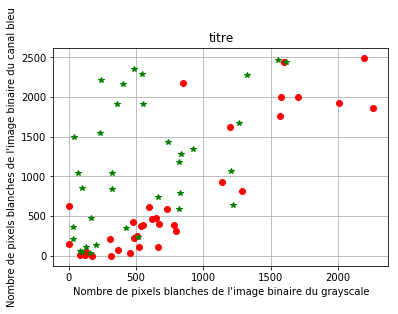

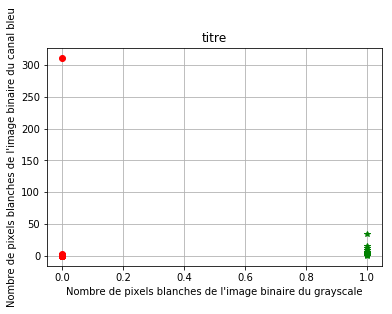

In [16]:
# blue2_nb_pixel_white > grayscale_nb_pixel_white ==> spiral

def ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        X_train_plot[i][0] = np.sum(X_train_binary[i] == 255)
        X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) #or np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

def ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_binary[i] == 255) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) / np.sum(X_train_binary[i] == 255)
    return X_train_plot
        
def NumberOfRatioHigherThan(ratio, array):
    totalSmooth = 0
    totalSpiral = 0
    for i in range(0, len(array)):
        if Y_train[i][1] == "smooth" :
            if array[i][1] > ratio :
                totalSmooth += 1
        elif Y_train[i][1] == "spiral" :
            if  array[i][1] > ratio :
                totalSpiral += 1
    return totalSmooth, totalSpiral

arrayOfThings = ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale()
nbSmooth, nbSpiral = NumberOfRatioHigherThan(2.0, arrayOfThings)
nbSmoothLesser = len(X_train)/2 - nbSmooth
nbSpiralLesser = len(X_train)/2 - nbSpiral
print("Nbr smooth high = %d, Nbr smooth lesser = %d \nNbr spiral = %d, Nbr spiral lesser = %d" %(nbSmooth, nbSmoothLesser, nbSpiral, nbSpiralLesser))

def Entropie(p1, p2, t):
    entropie = -(p1/t*np.log2(p1/t))-(p2/t*np.log2(p2/t))
    return entropie

def Gain(p1, p2, t, e1, e2, e3):
    gain = e3 - p1/t*e1 - p2/t*e2
    return gain

#print(Entropie(29, 35, 64))
#print(Entropie(21, 5, 26))
#print(Entropie(8, 30, 38))
#print(Gain(21, 5, 26, Entropie(21, 5, 26), Entropie(8, 30, 38), Entropie(29, 35, 64)))
TracePlot(ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
TracePlot(ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")

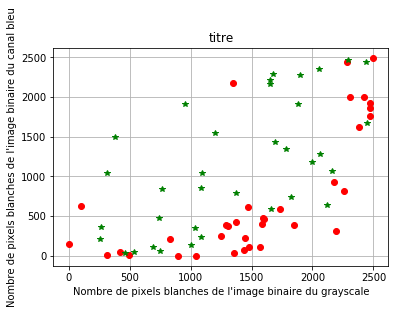

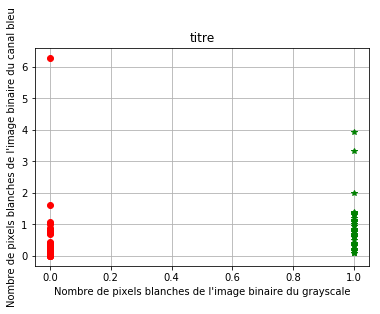

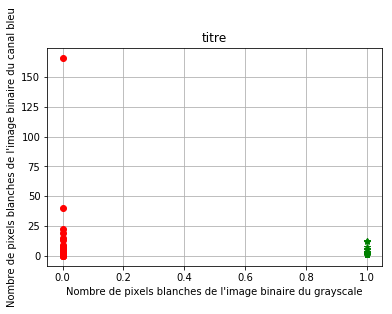

In [17]:
def ExtractNbOfBluePixelsVersusAverageYellow():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        X_train_plot[i][0] = np.sum(X_train_crop_yellow[i] == 1)
        X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) #or np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

def ExtractRatioBlueVsYellow():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_crop_yellow[i] == 1) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) / np.sum(X_train_crop_yellow[i] == 1)
    return X_train_plot

def ExtractRatioYellowVsBlue():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_crop_blue_mid[i] == 255) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_yellow[i] == 1) / np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

TracePlot(ExtractNbOfBluePixelsVersusAverageYellow(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
TracePlot(ExtractRatioBlueVsYellow(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
TracePlot(ExtractRatioYellowVsBlue(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")


In [19]:
def GetStretchRatio(img, threshold):
    
    img = img[...,::-1]
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, grayscale = cv2.threshold(grayscale,threshold,255, cv2.THRESH_BINARY)
    binary, contours, hierarchy = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 255

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)

    # Trouver le plus gros blob
    mx = (0,0,0)
    mx_area = 0
    ratio = 0.0
    for cont in contours:
        rect = cv2.minAreaRect(cont)
        tempbox = cv2.boxPoints(rect)
        p1 = tempbox[0] - tempbox[1]    # points
        p2 = tempbox[3] - tempbox[0]
        c1 = p1[1]  # coordonnées
        c2 = p2[0]
        area = c1 * c2
        if area > mx_area:
            mx = rect
            mx_area = area
            ratio = min(c1,c2) / max(c1,c2)
    # box = cv2.boxPoints(mx)
    # box = np.int0(box)

    # Pour debug/voir le minRect
    # cv2.drawContours(binary, [box], 0, (255, 0, 0))
    # cv2.imshow("contours", binary)
    # cv2.waitKey(0)

    return ratio

def ExtractRatio(threshold):
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1    
        X_train_plot[i][1] = GetStretchRatio(X_train_crop[i].reshape(50,50,3), threshold)
    return X_train_plot

In [20]:
# Stats
def Mean(array):
    count_smooth = 0
    count_spiral = 0
    sum_smooth = 0
    sum_spiral = 0
    for i in range(0, len(array)): 
        if Y_train[i][1] == "smooth" :
            count_smooth += 1
            sum_smooth+= array[i][1]
        elif Y_train[i][1] == "spiral" :
            count_spiral += 1
            sum_spiral+= array[i][1]
    
    print("Mean Smooth: ", sum_smooth/count_smooth)
    print("Mean Spiral: ", sum_spiral/count_spiral)


def Median(array):
    count_smooth = 0
    count_spiral = 0
    med_smooth = 0
    med_spiral = 0
    med = np.round(len(Y_train)/4)
    for i in range(0, len(array)): 
        if Y_train[i][1] == "smooth" :
            count_smooth += 1
            if count_smooth == med:
                med_smooth = array[i][1]
        elif Y_train[i][1] == "spiral" :
            count_spiral += 1
            if count_spiral == med:
                med_smooth = array[i][1]
                
    print("Median Smooth: ", med_smooth)
    print("Median Spiral: ", med_spiral)

Mean Smooth:  0.8517399787902832
Mean Spiral:  0.6833404294082097
Median Smooth:  0.800000011920929
Median Spiral:  0


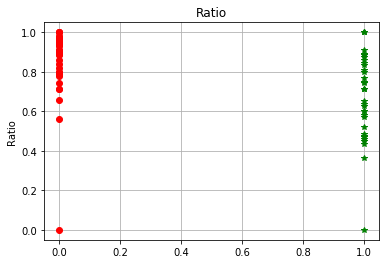

In [21]:
ratio_arr = ExtractRatio(127)
Mean(ratio_arr)
Median(ratio_arr)
TracePlot(ratio_arr, "Ratio", "", "Ratio")

In [32]:
# Export Data
# ['ratio longueur/largeur', 'pixels blanches grayscale', 'pixels bleu']

num_features = 3 + 1

ratio = ExtractRatio(127) 
whitePixel = ExtractNumberOfBlackAndWhitePixels(X_train_binary)
bluePixel = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale()

def ExportData():
    feature_vector = np.zeros((70, num_features), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            feature_vector[i] = [ratio[i][1], whitePixel[i][0], bluePixel[i][1], 0]
        elif Y_train[i][1] == "spiral" :
            feature_vector[i] = [ratio[i][1], whitePixel[i][0], bluePixel[i][1], 1]
    
        print (feature_vector[i]) 

    np.savetxt("galaxy_train.csv", feature_vector, delimiter=",")

In [33]:
ExportData()

[  0.95804197 599.         608.           0.        ]
[  0.9523809 728.        586.          0.       ]
[  0.95000017 364.          74.           0.        ]
[  0.93103451 506.         254.           0.        ]
[  0.94117647 799.         312.           0.        ]
[  0.81818181 477.         425.           0.        ]
[  0.85714287 648.         476.           0.        ]
[8.97959173e-01 2.19200000e+03 2.49300000e+03 0.00000000e+00]
[8.95833313e-01 1.19500000e+03 1.62600000e+03 0.00000000e+00]
[9.66666639e-01 1.70200000e+03 2.00400000e+03 0.00000000e+00]
[  0.93939394 667.         396.           0.        ]
[8.99999976e-01 1.56600000e+03 1.75900000e+03 0.00000000e+00]
[6.59090936e-01 8.49000000e+02 2.18000000e+03 0.00000000e+00]
[ 1. 87. 14.  0.]
[8.00000012e-01 1.59500000e+03 2.44600000e+03 0.00000000e+00]
[9.78260875e-01 2.00500000e+03 1.92700000e+03 0.00000000e+00]
[7.40740716e-01 7.84000000e+02 3.87000000e+02 0.00000000e+00]
[  0.71428573 176.           0.           0.        ]
[  0

In [34]:
# Import train Data

num_features = 3

data_train = np.loadtxt("galaxy_train.csv", delimiter=",")

X_train  = data_train[:,0:num_features]
Y_train  = data_train[:,num_features]

model = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10)
model = model.fit(X_train, Y_train)


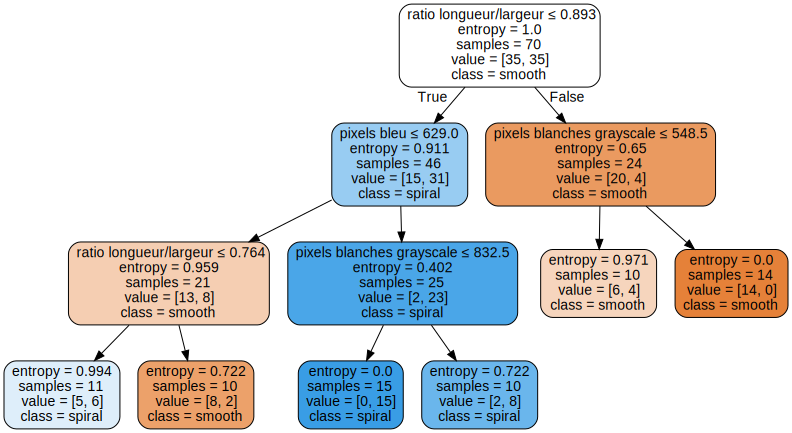

In [36]:
# Export Tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['ratio longueur/largeur', 'pixels blanches grayscale', 'pixels bleu'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_data") 
graph